In [1]:
# Libraries :

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats # Pour la randomsearch
from scipy.stats import uniform, randint

import time

# Model dev part :
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import recall_score # Minimisation des Faux Negatifs, ie les clients qui vont quitter mais qu'on ne detecte pas => on veut pas perdre de clients
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score 
from sklearn.metrics import classification_report

# Models :

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

In [2]:
data = pd.read_csv('churn_prediction_fictional_ibm 1 1.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# EDA :

In [3]:
print("data shape :", data.shape)

print("Repartition de Churn :\n", data['Churn'].value_counts()/len(data)*100,"\n")

print(data.info())

print('Nb de valeur unique :', data.nunique())

data shape : (7043, 21)
Repartition de Churn :
 Churn
No     73.463013
Yes    26.536987
Name: count, dtype: float64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   

* 26% de churn, pas besoin de rééquilibrer les classes a priori (prq pas essayer)
* Pas de données manquantes a premiere vue
* Plusieurs type de variables à changer (object -> float64) : TotalCharges 
* Suppr customerID pour la suite c'est pas utile.
* Variables binaires a convertir en 0-1

In [4]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

data.drop('customerID',axis=1,inplace=True)

* Redondance : PhoneService et MultipleLines (On suppr PhoneService)
* Beaucoup de var avec No internet Service, je pourrais supprimer quand je ferai mon one-hot

* Numeric : MonthlyCharges, TotalCharges, tenure

## Outliers : 

In [27]:
num = ['TotalCharges','tenure','MonthlyCharges']
cat=list(data.columns)
cat.remove('TotalCharges')
cat.remove('tenure')
cat.remove('MonthlyCharges')

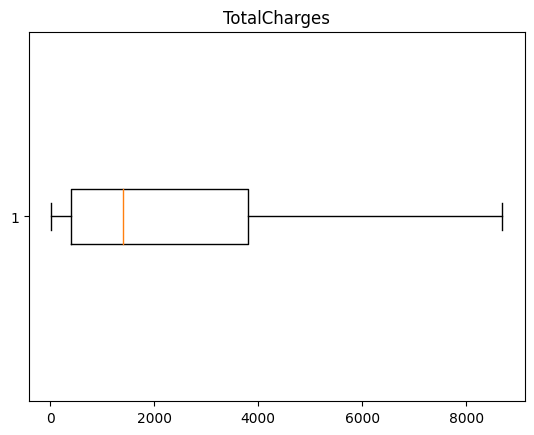

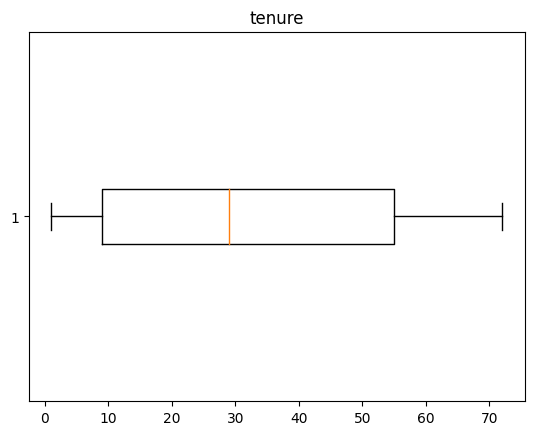

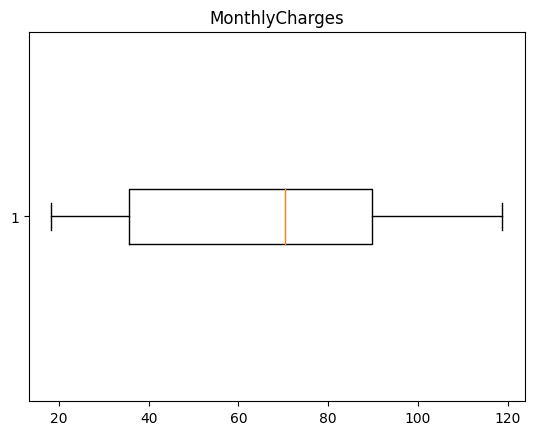

In [ ]:
for c in num : 
    plt.boxplot(data[c],vert=False)
    plt.title(c)
    plt.show()b

In [31]:
for c in cat : 
    print(data[c].value_counts())

gender
Male      3549
Female    3483
Name: count, dtype: int64
SeniorCitizen
0    5890
1    1142
Name: count, dtype: int64
Partner
No     3639
Yes    3393
Name: count, dtype: int64
Dependents
No     4933
Yes    2099
Name: count, dtype: int64
PhoneService
Yes    6352
No      680
Name: count, dtype: int64
MultipleLines
No                  3385
Yes                 2967
No phone service     680
Name: count, dtype: int64
InternetService
Fiber optic    3096
DSL            2416
No             1520
Name: count, dtype: int64
OnlineSecurity
No                     3497
Yes                    2015
No internet service    1520
Name: count, dtype: int64
OnlineBackup
No                     3087
Yes                    2425
No internet service    1520
Name: count, dtype: int64
DeviceProtection
No                     3094
Yes                    2418
No internet service    1520
Name: count, dtype: int64
TechSupport
No                     3472
Yes                    2040
No internet service    1520
Name: c

## Correlation :

In [61]:
data.drop('PhoneService',axis=1,inplace=True) # Redondante

data['gender'] = (data['gender'] == 'Male').astype('int64') #Binaire
data['Partner'] = (data['Partner'] == 'Yes').astype('int64')
data['Dependents'] = (data['Dependents'] == 'Yes').astype('int64')
data['PaperlessBilling'] = (data['PaperlessBilling'] == 'Yes').astype('int64')
data['Churn'] = (data['Churn'] == 'Yes').astype('int64')

data_dum=pd.get_dummies(data,dtype=int)
data_dum.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (a

In [62]:
data_dum.drop(['OnlineSecurity_No internet service','OnlineBackup_No internet service','DeviceProtection_No internet service',
           'TechSupport_No internet service','StreamingTV_No internet service','StreamingMovies_No internet service'],axis=1,inplace=True)
data_dum.columns # Certaines var ressortent binaire autant les recup en binaire comme les autres avec les Yes = 1 et on suppr la col No

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_Yes',
       'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [63]:
data_dum.drop(['OnlineSecurity_No','OnlineBackup_No','DeviceProtection_No',
           'TechSupport_No','StreamingTV_No','StreamingMovies_No','MultipleLines_No'],axis=1,inplace=True)
data_dum.rename(columns={'OnlineSecurity_Yes' :'OnlineSecurity','OnlineBackup_Yes' :'OnlineBackup','DeviceProtection_Yes' :'DeviceProtection',
                         'TechSupport_Yes' :'TechSupport','StreamingTV_Yes' :'StreamingTV','StreamingMovies_Yes' :'StreamingMovies','MultipleLines_Yes' : 'MultipleLines'},inplace=True)
data_dum.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'MultipleLines_No phone service', 'MultipleLines',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

<Axes: >

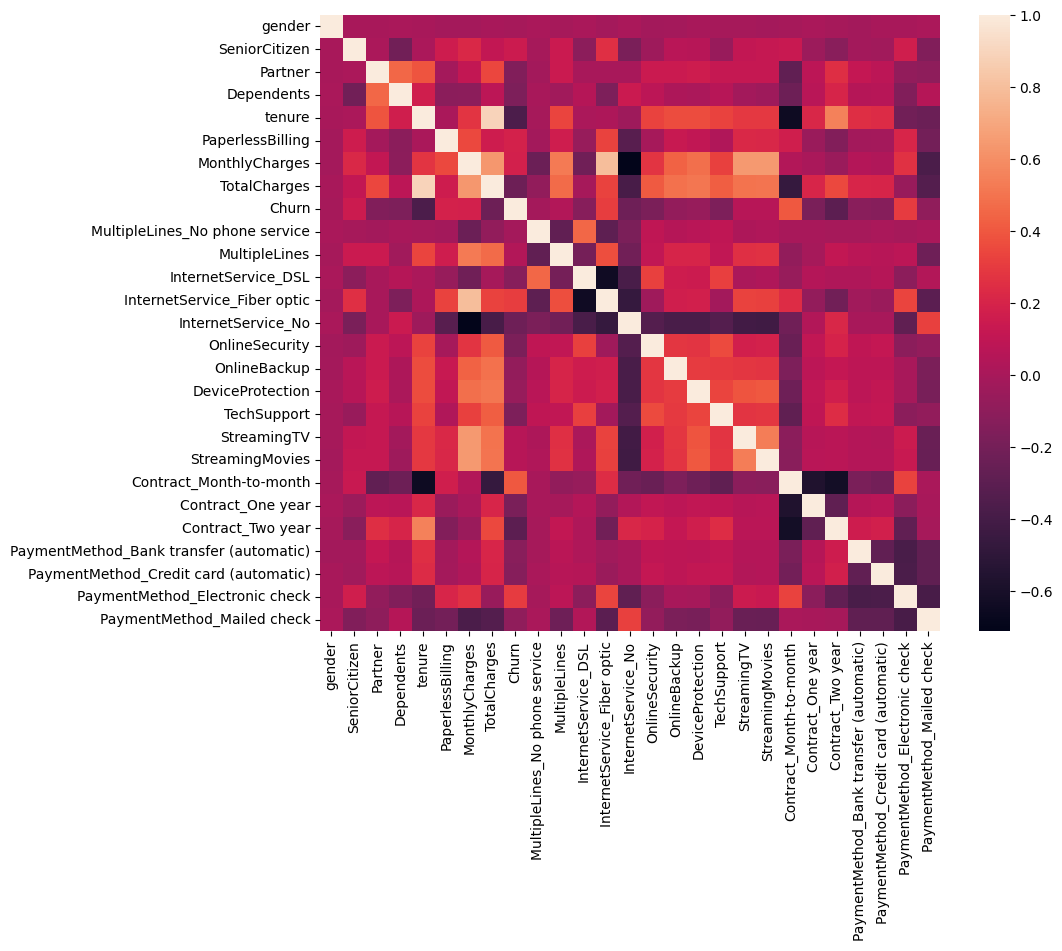

In [64]:
corr=data_dum.corr('spearman')
plt.figure(figsize=(10,8))
sns.heatmap(corr)

<Axes: xlabel='Churn'>

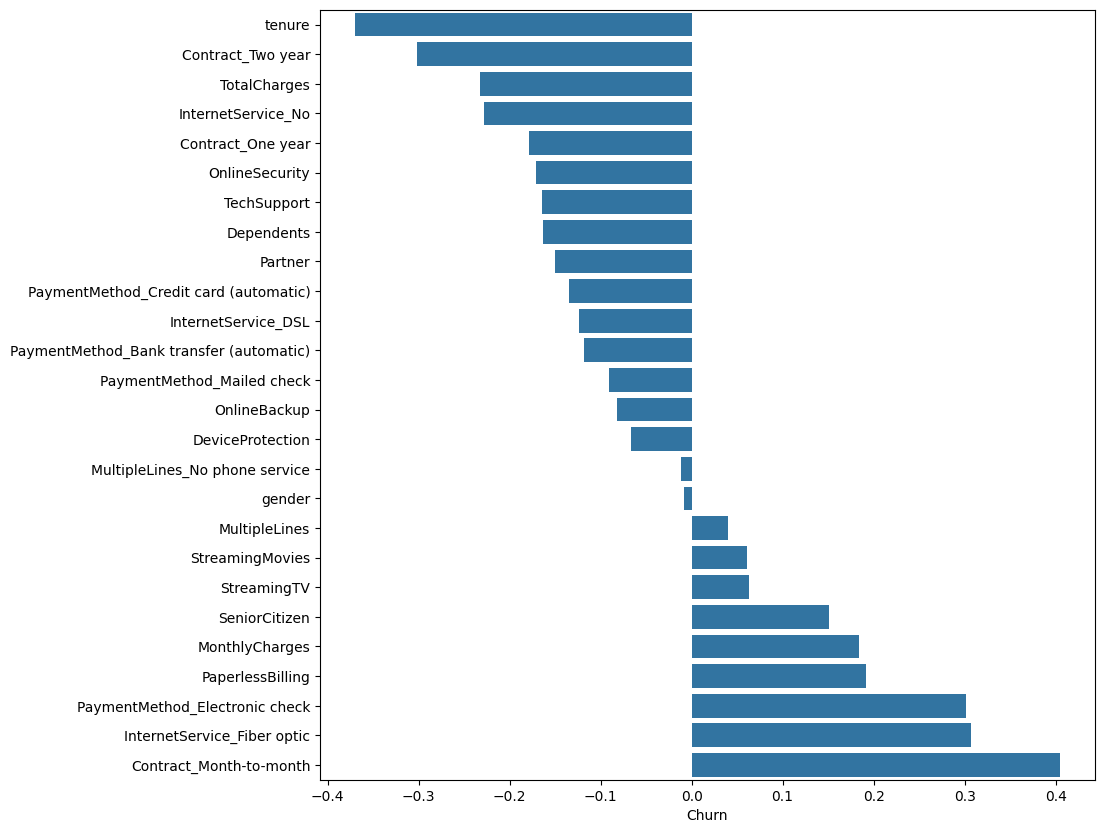

In [65]:
plt.figure(figsize=(10,10))
sns.barplot(corr['Churn'].sort_values()[:-1],orient='h')

In [66]:
data_dum.drop(['gender',"MultipleLines_No phone service"],axis=1,inplace=True) # Quasi 0 de corrélation

# Modelisation :

In [67]:
# Séparation train / test :
X_train, X_test, y_train, y_test = train_test_split(data_dum.drop('Churn',axis=1),data_dum['Churn'],test_size=0.25,random_state=1,shuffle=True) #75/25

# On scale les variables numeriques : tenure, MonthlyCharges, TotalCharges
num = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler=StandardScaler()
X_train[num] = scaler.fit_transform(X_train[num])
X_test[num] = scaler.transform(X_test[num])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5274, 24), (1758, 24), (5274,), (1758,))

In [ ]:
X_train[num].describe() # Pas d'outliers particulier : entre -1mu et 3mu

,tenure,MonthlyCharges,TotalCharges
count,5.274000e+03,5.274000e+03,5.274000e+03
mean,1.226003e-16,-1.091277e-16,1.630180e-16
std,1.000095e+00,1.000095e+00,1.000095e+00
min,-1.274410e+00,-1.550638e+00,-9.962724e-01
25%,-9.484841e-01,-9.679688e-01,-8.341165e-01
50%,-1.336703e-01,1.791361e-01,-3.864650e-01
75%,9.255877e-01,8.297700e-01,6.548534e-01
max,1.618180e+00,1.781270e+00,2.798221e+00


              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1294
           1       0.65      0.54      0.59       464

    accuracy                           0.80      1758
   macro avg       0.75      0.72      0.73      1758
weighted avg       0.79      0.80      0.79      1758



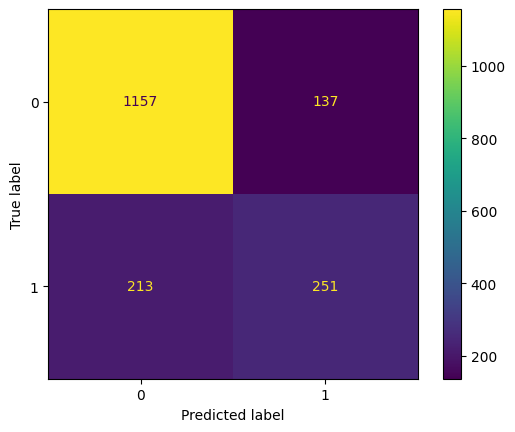

In [71]:
# Baseline model :
base = LogisticRegression()
base.fit(X_train,y_train)
y_pred=base.predict(X_test)
y_prob = base.predict_proba(X_test)[:,1]
print(classification_report(y_test,y_pred))
ConfusionMatrixDisplay.from_estimator(base, X_test, y_test)

Auc :  0.8502021931460855


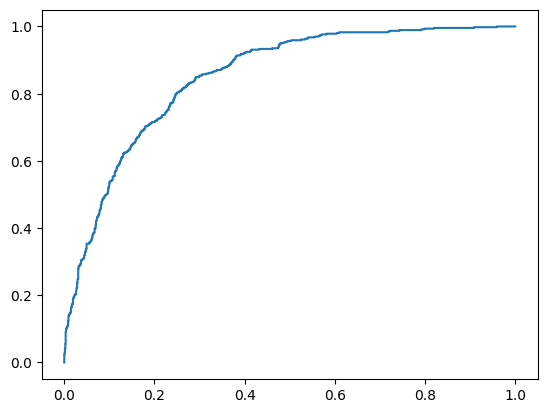

In [72]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
print('Auc : ', roc_auc_score(y_test,y_prob))
plt.plot(fpr, tpr)

Axes(0.125,0.11;0.775x0.77)


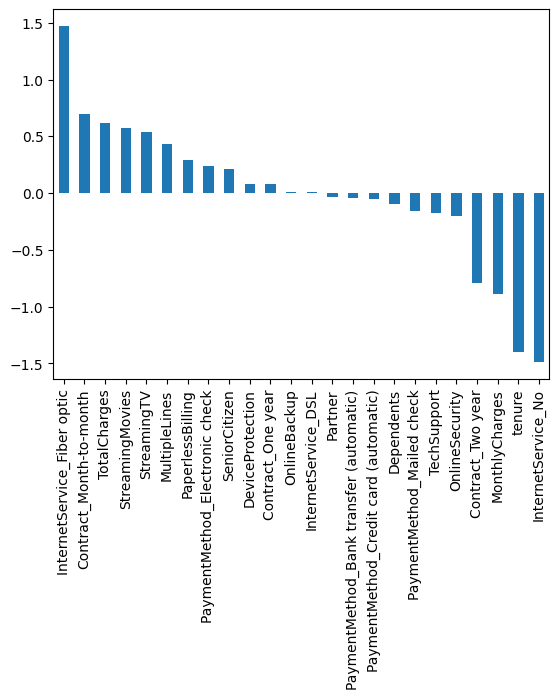

In [73]:
weights = pd.Series(base.coef_[0],
                 index=X_train.columns.values)
print (weights.sort_values(ascending = False).plot(kind='bar'))

In [75]:
# Hyperparameters optimisation :
def cv(model,distrib,X=X_train,y=y_train) :
    process = RandomizedSearchCV(estimator=model,param_distributions=distrib,n_iter=50,scoring="recall",cv=5,verbose=0,n_jobs=-1,random_state=1)
    process.fit(X,y)
    return process.best_params_, process.best_score_

In [77]:
# Define the differents models and there distribution for RandomCV :

reglog=LogisticRegression()
reglog_distrib = {'C': uniform(0.0001,100), 'max_iter': [100, 200, 500]}

knn=KNeighborsClassifier()
knn_distrib = {'n_neighbors' : randint(3,20), 'weights' : ['uniform','distance'],}

svc = SVC()
svc_distrib = {'C': uniform(0.0001,100), 'kernel': ['linear', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto'], 'coef0': uniform(0,1)}

rf = RandomForestClassifier()
rf_distrib = {'n_estimators' : randint(50,501), 'max_depth':[None, 10, 20, 30, 50], 'min_samples_split': randint(2,11),
           'min_samples_leaf': randint(1,6), 'max_features':["sqrt", "log2", None]}

xgb = XGBClassifier()
xgb_distrib = {'n_estimators' : randint(50,501), 'max_depth': randint(1,11), 'subsample': uniform(0.5,0.5), 'learning_rate' : uniform(0.001,0.3), 'colsample_bytree': uniform(0.5,0.5),
            'gamma' : uniform(0,5), 'reg_alpha' : uniform(0.1,10), 'reg_lambda' : uniform(0.1,10)} # 'super' object has no attribute '__sklearn_tags__'


models = [reglog, knn, svc, rf, xgb]
distribs = [reglog_distrib, knn_distrib, svc_distrib, rf_distrib, xgb_distrib]
model_names= ['Logistic Reg','KNN','SVC','RandomForest','Xgboost']

In [80]:
# Optimization :
params=dict()
res=dict()
times=dict()
for (model, distrib, model_name) in zip(models,distribs,model_names) :
    print(model_name)
    start=time.time()
    param, score=cv(model,distrib)
    end=time.time()
    print(end-start)
    params[model_name]=param
    res[model_name]=score
    times[model_name]=end-start

Logistic Reg
3.735996961593628
KNN
3.256998300552368
SVC
72.95000743865967
RandomForest
90.436030626297
Xgboost
10.629571676254272


In [81]:
res

{'Logistic Reg': 0.5516014234875446,
 'KNN': 0.5523131672597865,
 'SVC': 0.5416370106761565,
 'RandomForest': 0.5217081850533808,
 'Xgboost': 0.5587188612099643}

In [103]:
# Models optimisés :
reglog = LogisticRegression(**params['Logistic Reg'])

knn = KNeighborsClassifier(**params['KNN'])

svc = SVC(**params['SVC'],probability=True)

rf = RandomForestClassifier(**params['RandomForest'])

xgb = XGBClassifier(**params['Xgboost'])

models = [reglog, knn, svc, rf,xgb]
model_names=['Logistic Reg','KNN','SVC','RandomForest','Xgboost']

In [104]:
for model,model_name in zip(models,model_names) : # Entrainement des modeles optimisés et metrics sur le test 
  model.fit(X_train,y_train)
  y_pred=model.predict(X_test)
  print(model_name, classification_report(y_test,y_pred),'\n')

Logistic Reg               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1294
           1       0.65      0.55      0.59       464

    accuracy                           0.80      1758
   macro avg       0.75      0.72      0.73      1758
weighted avg       0.79      0.80      0.80      1758
 

KNN               precision    recall  f1-score   support

           0       0.85      0.88      0.86      1294
           1       0.62      0.57      0.59       464

    accuracy                           0.79      1758
   macro avg       0.74      0.72      0.73      1758
weighted avg       0.79      0.79      0.79      1758
 

SVC               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1294
           1       0.64      0.56      0.59       464

    accuracy                           0.80      1758
   macro avg       0.74      0.72      0.73      1758
weighted avg       0.79      0.80      0.79      

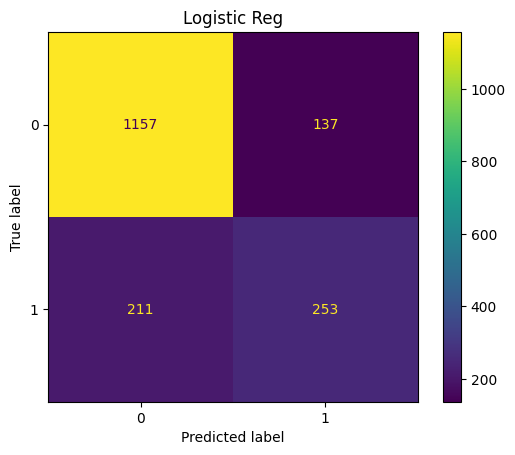

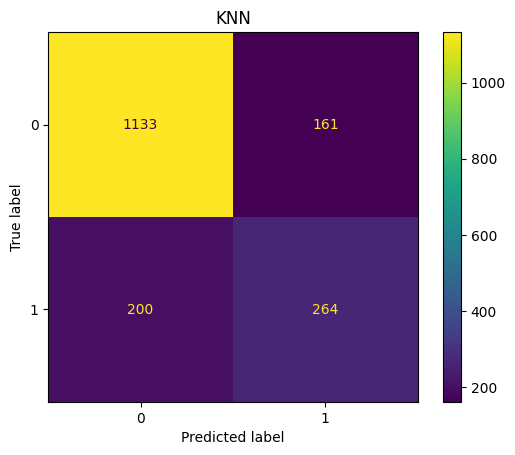

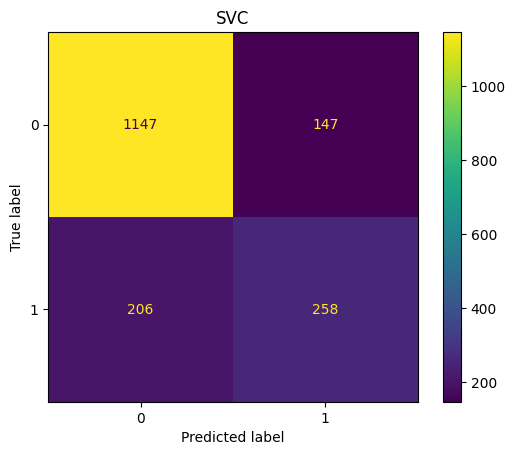

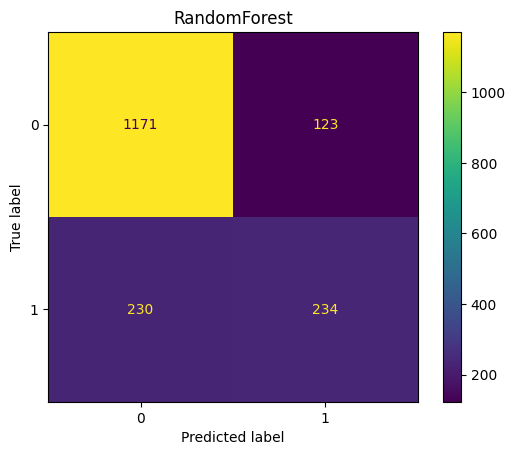

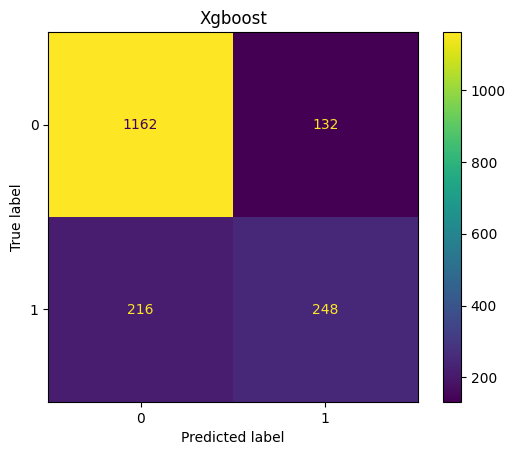

In [105]:
for model,model_name in zip(models,model_names) :
  ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
  plt.title(model_name)

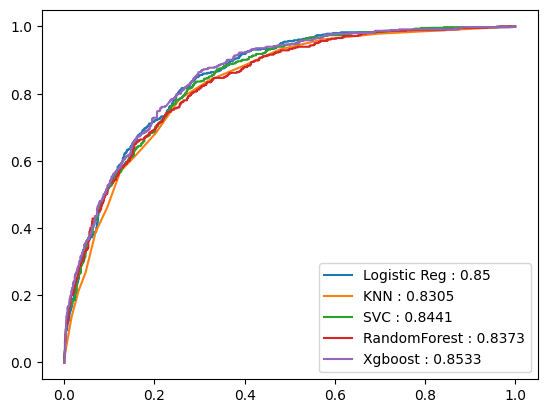

In [125]:
leg = list()
for i, model, model_name in zip(range(len(model_names)),models, model_names) :
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr)
    leg.append(model_name + ' : ' + str(round(roc_auc_score(y_test,y_prob),4)))
    plt.legend(leg)
    

## Ensemble models : 

In [130]:
# Ensemble Models:
base_models = [
    ('reglog', reglog),
    ('knn', knn),
    ('svc', svc),
    ('rf', rf),
    ('xgb', xgb)
]

voting_model = VotingClassifier(estimators=base_models, voting='hard')

voting_model

VotingClassifier(estimators=[('reglog',
                              LogisticRegression(C=41.702300470257406)),
                             ('knn', KNeighborsClassifier(n_neighbors=17)),
                             ('svc',
                              SVC(C=71.73926012578099, coef0=0.6129480927278149,
                                  gamma='auto', kernel='linear',
                                  probability=True)),
                             ('rf',
                              RandomForestClassifier(max_depth=10,
                                                     max_features=None,
                                                     min_samples_leaf=2,
                                                     min_samples_split=8,
                                                     n_estimators=290)),
                             ('...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.23285512806011177,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=9,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=80, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))])

In [127]:
# Fitting the models to train data :
for (model,model_name) in zip(models,model_names) :
    model.fit(X_train,y_train.values.ravel());

voting_model.fit(X_train, y_train.values.ravel());

In [2]:
y_pred = voting_model.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(voting_model, X_test, y_test)
plt.title('Voting Model')

NameError: name 'voting_model' is not defined

Des visualisations peuvent être ajoutées, des variables peuvent être supprimées suite à l'étude de la corrélation notamment. Nous avons un modèle proche du modèle que j'ai utilisé en temps que baseline (regression logistique sans optimisation de parametre) avec un recall à 55% ce qui n'est pas bon dans un cas de churn ou je veux avoir le moins de faux negatif possible. Les axes d'amélioration à voir sont principalement sur le travail sur le dataset je pense, essayer un SMOTE pour le rééquilibrage.

In [1]:
weights = pd.Series(reglog.coef_[0],
                 index=X_train.columns.values)
print (weights.sort_values(ascending = False).plot(kind='bar'))

NameError: name 'pd' is not defined

Les variables importantes à la prédiction de notre modèle de regression logistique sont TotalCharges et Tenure, ce qui est cohérent avec la description de ces variables. Le reste de variables à peu d'impact, un travail de feature engineering plus avancé doit être fait pour améliorer ça et trouver des variables à créer.